In [1]:
!pip install -q langgraph langchain_core langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 7.4 MB/s eta 0:00:00


In [2]:
from langchain_groq import ChatGroq
from google.colab import userdata
GROQ_API_KEY=userdata.get('GROQ_API_KEY')
llm=ChatGroq(groq_api_key=GROQ_API_KEY,model_name="llama-3.2-90b-text-preview")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7e846e16a7d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7e846e1dc6d0>, model_name='llama-3.2-90b-text-preview', model_kwargs={}, groq_api_key=SecretStr('**********'))

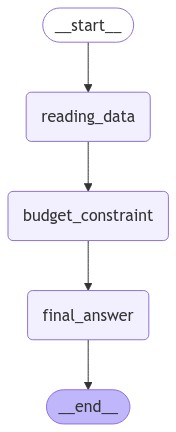

In [37]:
import json
from typing import TypedDict

class OverallState(TypedDict):
    answer: str
    path: str
    ON_of_products: str
    ON_of_ingredients: str
    budget: int
    data: list[any]

class InputState(TypedDict):
    path: str

class OutputState(TypedDict):
    answer: str

def read_data(state: InputState) -> OverallState:
    """ A function to read JSON data"""
    with open(state['path'], encoding='utf-8') as f:
        data = json.load(f)
        data = data['products']
    return {'data': data, 'path': state['path'], 'ON_of_products': '', 'ON_of_ingredients': '', 'answer': '', 'budget': 2500}

from langchain_core.prompts import ChatPromptTemplate
sys_prompt = """
You are an expert in optimizing ingredient pack purchases under a strict budget.

- Your task is to calculate the minimum number of packs required for each of 34 ingredients, ensuring all fit within the specified budget.
- Each ingredient has a fixed buying price per pack (e.g., $1.3 for 1000ml of milk or $11.2 for a 500ml pack of caramel sauce).
- For each ingredient, calculate the number of packs needed to stay within the budget constraints, while ensuring every ingredient has at least one pack (minimum pack count is 1).
- Do not make up anything by youeself. Every ingredients should exactly match.
### Output Format:
- Please provide the output as a list of ingredients and their pack counts in this exact format:
  `Ingredient1: PackCount1, Ingredient2: PackCount2, ..., Ingredient34: PackCount34`
- The output must include exactly 34 ingredients with their pack counts (no omissions).

### Budget Constraints:
- The budget must be respected exactly, using the equation:
  `buying_price1 * pack_count1 + buying_price2 * pack_count2 + ... + buying_price34 * pack_count34 <= Budget`

### Additional Guidelines:
- Distribute the budget efficiently to minimize excess pack counts.
- Ensure all pack counts are integers, with no zero values.

Calculate the optimal solution and provide the final pack counts in the specified format.

"""

llm_prompt = ChatPromptTemplate.from_messages([('system', sys_prompt), ('human', "{data}"), ('human', "{budget}")])

chain = llm_prompt | llm

def budget_constraint(state: OverallState):
    """A tool to consider budget constraint on calculating optimum number of packs for each ingredient"""
    data = state['data']

    # Use fixed buying prices directly for each pack type
    answer = chain.invoke({'budget': state['budget'], 'data': data})

    return {"ON_of_ingredients": answer}

def final_answer(state: OverallState) -> OutputState:
    answer = state['ON_of_ingredients']
    prompt = """
    This is a generated answer. I want you to just print the optimum number of ingredient packs with their name like Milk:5, Water:10, ...
    Without any preamble:
    {answer}
    """
    final_prompt_template = ChatPromptTemplate.from_template(template=prompt)
    final_prompt = final_prompt_template.format(answer=answer)

    final_answer = llm.invoke(final_prompt)

    return {'answer': final_answer}

from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node('reading_data', read_data)
builder.add_node('budget_constraint', budget_constraint)
builder.add_node('final_answer', final_answer)

builder.add_edge(START, 'reading_data')
builder.add_edge('reading_data', 'budget_constraint')
builder.add_edge('budget_constraint', 'final_answer')
builder.add_edge('final_answer', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

for output in graph.stream({'path': '/content/Full_Dataset.json'}, stream_mode='values'):
    final_answer=output



In [38]:
final_answer['answer'].pretty_print()

================================== Ai Message ==================================

Espresso beans: 4, Water: 6, Black tea loose leaf: 3, Green tea loose leaf: 2, Dried hibiscus flowers: 1, Dried mint leaf: 1, Honey: 12, All-purpose flour: 10, Sugar: 20, Cocoa powder: 4, Baking powder: 12, Baking soda: 2, Salt: 10, Ground cinnamon: 1, Ground ginger: 1, Eggs: 20, Milk: 20, Vegetable oil: 10, Vanilla extract: 3, Butter: 10, Cream cheese: 10, Cream: 10, Graham cracker crumbs: 2, Lemon juice: 10, Strawberries: 10, Banana: 25, Mango: 5, Peanut butter: 2, Yogurt: 5, Ice-cream: 50, Chocolate syrup: 2, Caramel sauce: 2, Dried ginger root: 10, Grated carrots: 2
